# CHFS IOR Result Visualizer

`results/chfs/*/ior_results/ior_result_*.json` から IOR のサマリ JSON を読み込み、操作別の帯域やレイテンシを可視化します。

In [1]:
from pathlib import Path
import json
import re

import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from IPython.display import display

# 手動で実験を指定する場合はここを編集
SELECTED_EXPERIMENTS: list[str] | None = None  # 最新の実験を自動選択

# Plot style configuration
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.grid": True,
    "grid.alpha": 0.3,
})
pl.Config.set_tbl_rows(100)

DATA_DIR = (Path.cwd() / "processed" / "chfs").resolve()
DATA_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = (Path.cwd() / "fig" / "chfs").resolve()
FIG_DIR.mkdir(parents=True, exist_ok=True)

def save(fig, name: str) -> None:
    for ext in ("png", "pdf"):
        fig.savefig(FIG_DIR / f"{name}.{ext}", bbox_inches="tight", dpi=150)

def comma_formatter(value, _):
    return f"{value:,.0f}"

def slugify(value: str) -> str:
    cleaned = re.sub(r"[^A-Za-z0-9._-]+", "_", value)
    return cleaned.strip("_") or "unknown"

In [2]:
def resolve_results_root() -> Path:
    candidates = [
        Path("results"),
        Path("..") / "results",
        Path("../..") / "results",
    ]
    for candidate in candidates:
        if candidate.exists():
            return candidate.resolve()
    raise FileNotFoundError("results ディレクトリが見つかりません。ノートブックの位置を確認してください。")

results_root = resolve_results_root()
print(f"Using results directory: {results_root}")

Using results directory: /work/0/NBB/rmaeda/workspace/rust/benchfs/results


In [3]:
def fix_ior_json(content: str) -> str:
    """Fix common IOR JSON output format bugs.
    
    IOR 4.0.0 has several JSON formatting issues:
    1. Double closing brackets after Results array: ]] -> ]
    2. Extra closing bracket at the end of tests array
    3. Trailing commas before closing braces/brackets
    """
    content = re.sub(r'\]\s*\]\s*,\s*"max":', r'], "max":', content)
    content = re.sub(r'\}\s*\]\s*\]\s*,\s*"summary":', r'}], "summary":', content)
    content = re.sub(r',\s*\}', '}', content)
    content = re.sub(r',\s*\]', ']', content)
    return content

def safe_load_json(path: Path) -> dict | None:
    """Load JSON file with automatic fix for IOR format issues."""
    try:
        content = path.read_text()
        try:
            return json.loads(content)
        except json.JSONDecodeError:
            pass
        fixed_content = fix_ior_json(content)
        return json.loads(fixed_content)
    except (OSError, json.JSONDecodeError) as exc:
        print(f"Warning: Failed to parse {path}: {exc}")
        return None

In [4]:
IOR_JSON_PATTERN = re.compile(r"ior_result_(\d+)\.json$")

def parse_number(value):
    if value is None:
        return None
    if isinstance(value, (int, float)):
        return float(value)
    if isinstance(value, str):
        cleaned = value.replace(",", "").strip()
        if cleaned == "":
            return None
        try:
            return float(cleaned)
        except ValueError:
            return None
    return None

def extract_params_from_command(command: str) -> dict:
    """Extract IOR parameters from command line string."""
    params = {}
    # Transfer size: -t 4m
    match = re.search(r'-t\s+(\S+)', command)
    if match:
        params['transfer_size_str'] = match.group(1)
    # Block size: -b 512m
    match = re.search(r'-b\s+(\S+)', command)
    if match:
        params['block_size_str'] = match.group(1)
    # File per proc: -F flag
    params['file_per_proc'] = 1 if ' -F' in command or command.endswith('-F') else 0
    # CHFS chunk size
    match = re.search(r'--chfs\.chunk_size=(\d+)', command)
    if match:
        params['chfs_chunk_size'] = int(match.group(1))
    return params

def extract_nodes_from_run(run_name: str) -> int | None:
    """Extract node count from run directory name like '2025.12.04-01.19.22-409253.nqsv-16'."""
    match = re.search(r'-(\d+)$', run_name)
    return int(match.group(1)) if match else None

def load_ior_json(root: Path) -> tuple[pl.DataFrame, pl.DataFrame]:
    summary_records = []
    detail_records = []
    
    # Look for CHFS results
    for path in sorted(root.glob("chfs/**/ior_results/ior_result_*.json")):
        data = safe_load_json(path)
        if data is None:
            continue
            
        rel_parts = path.relative_to(root).parts
        match = IOR_JSON_PATTERN.search(path.name)
        run_index = int(match.group(1)) if match else None
        
        command = data.get("Command line", "")
        cmd_params = extract_params_from_command(command)
        
        # Extract node count from run directory name
        run_name = rel_parts[2] if len(rel_parts) > 2 else ""
        nnodes = extract_nodes_from_run(run_name)
        
        base = {
            "ior_file": str(path.relative_to(root)),
            "collection": "/".join(rel_parts[:-1]),
            "backend": rel_parts[0] if len(rel_parts) > 0 else "",
            "experiment": rel_parts[1] if len(rel_parts) > 1 else "",
            "run": run_name,
            "run_index": run_index,
            "nnodes": nnodes,
            "chfs_chunk_size": cmd_params.get("chfs_chunk_size"),
        }
        
        began = data.get("Began", "")
        finished = data.get("Finished", "")
        
        for summary in data.get("summary", []) or []:
            record = base | {
                "command": command,
                "began": began,
                "finished": finished,
                "operation": summary.get("operation"),
                "bw_max_mib": parse_number(summary.get("bwMaxMIB")),
                "bw_min_mib": parse_number(summary.get("bwMinMIB")),
                "bw_mean_mib": parse_number(summary.get("bwMeanMIB")),
                "bw_std_mib": parse_number(summary.get("bwStdMIB")),
                "ops_max": parse_number(summary.get("OPsMax")),
                "ops_min": parse_number(summary.get("OPsMin")),
                "ops_mean": parse_number(summary.get("OPsMean")),
                "ops_std": parse_number(summary.get("OPsSD")),
                "mean_time": parse_number(summary.get("MeanTime")),
                "xsize_mib": parse_number(summary.get("xsizeMiB")),
                "block_size_bytes": parse_number(summary.get("blockSize")),
                "transfer_size_bytes": parse_number(summary.get("transferSize")),
                "segment_count": summary.get("segmentCount"),
                "num_tasks": summary.get("numTasks"),
                "tasks_per_node": summary.get("tasksPerNode"),
                "repetitions": summary.get("repetitions"),
                "file_per_proc": summary.get("filePerProc"),
                "transfer_size_str": cmd_params.get("transfer_size_str", ""),
                "block_size_str": cmd_params.get("block_size_str", ""),
            }
            summary_records.append(record)
            
        for test in data.get("tests", []) or []:
            parameters = test.get("Parameters", {}) or {}
            options = test.get("Options", {}) or {}
            results = test.get("Results", []) or []
            
            for result in results:
                if result.get("access") == "remove":
                    continue
                detail_record = base | {
                    "command": command,
                    "test_id": test.get("TestID"),
                    "start_time": test.get("StartTime"),
                    "path": test.get("Path"),
                    "operation": result.get("access"),
                    "bw_mib": parse_number(result.get("bwMiB")),
                    "iops": parse_number(result.get("iops")),
                    "latency": parse_number(result.get("latency")),
                    "open_time": parse_number(result.get("openTime")),
                    "transfer_time": parse_number(result.get("wrRdTime")),
                    "close_time": parse_number(result.get("closeTime")),
                    "total_time": parse_number(result.get("totalTime")),
                    "block_kib": parse_number(result.get("blockKiB")),
                    "xfer_kib": parse_number(result.get("xferKiB")),
                    "segment_count": parameters.get("segmentCount"),
                    "transfer_size_bytes": parameters.get("transferSize"),
                    "block_size_bytes": parameters.get("blockSize"),
                    "num_tasks": options.get("tasks"),
                    "nodes": options.get("nodes"),
                    "tasks_per_node": options.get("clients per node"),
                    "transfer_size_str": cmd_params.get("transfer_size_str", ""),
                    "block_size_str": cmd_params.get("block_size_str", ""),
                    "file_per_proc": cmd_params.get("file_per_proc", 0),
                }
                detail_records.append(detail_record)
                
    summary_df = pl.DataFrame(summary_records) if summary_records else pl.DataFrame([])
    
    if not summary_df.is_empty():
        summary_df = (
            summary_df
            .with_columns(
                pl.col("num_tasks").cast(pl.Int64, strict=False),
                pl.col("tasks_per_node").cast(pl.Int64, strict=False),
                pl.col("repetitions").cast(pl.Int64, strict=False),
                pl.col("file_per_proc").cast(pl.Int64, strict=False),
                pl.col("segment_count").cast(pl.Int64, strict=False),
                pl.col("nnodes").cast(pl.Int64, strict=False),
                pl.col("chfs_chunk_size").cast(pl.Int64, strict=False),
                (pl.col("block_size_bytes") / (1024 ** 2)).alias("block_size_mib"),
                (pl.col("transfer_size_bytes") / (1024 ** 2)).alias("transfer_size_mib"),
                (pl.col("bw_mean_mib") / 1024.0).alias("bw_mean_gib"),
                (pl.col("bw_max_mib") / 1024.0).alias("bw_max_gib"),
                (pl.col("bw_min_mib") / 1024.0).alias("bw_min_gib"),
            )
            .with_columns(
                pl.when(pl.col("file_per_proc") == 1)
                .then(pl.lit("File-per-Process"))
                .otherwise(pl.lit("Shared File"))
                .alias("access_mode"),
            )
            .sort(["backend", "experiment", "run", "run_index", "operation"])
        )
        
    detail_df = pl.DataFrame(detail_records) if detail_records else pl.DataFrame([])
    
    if not detail_df.is_empty():
        detail_df = (
            detail_df
            .with_columns(
                pl.col("num_tasks").cast(pl.Int64, strict=False),
                pl.col("nodes").cast(pl.Int64, strict=False),
                pl.col("tasks_per_node").cast(pl.Int64, strict=False),
                pl.col("nnodes").cast(pl.Int64, strict=False),
                pl.col("chfs_chunk_size").cast(pl.Int64, strict=False),
                (pl.col("block_kib") / 1024.0).alias("block_mib"),
                (pl.col("xfer_kib") / 1024.0).alias("xfer_mib"),
                (pl.col("transfer_size_bytes") / (1024 ** 2)).alias("transfer_size_mib"),
                (pl.col("block_size_bytes") / (1024 ** 2)).alias("block_size_mib"),
                (pl.col("bw_mib") / 1024.0).alias("bw_gib"),
            )
            .with_columns(
                pl.when(pl.col("file_per_proc") == 1)
                .then(pl.lit("File-per-Process"))
                .otherwise(pl.lit("Shared File"))
                .alias("access_mode"),
            )
            .sort(["backend", "experiment", "run", "run_index", "operation", "test_id"])
        )
        
    return summary_df, detail_df

ior_summary_df, ior_detail_df = load_ior_json(results_root)

print(f"Loaded {len(ior_summary_df)} summary records and {len(ior_detail_df)} detail records")

if not ior_summary_df.is_empty():
    print(f"\nExperiments: {ior_summary_df['experiment'].unique().to_list()}")
    display(ior_summary_df.head(10).to_pandas())

Loaded 2 summary records and 2 detail records

Experiments: ['2025.12.04-01.19.09-default']


,ior_file,collection,backend,experiment,run,run_index,nnodes,chfs_chunk_size,command,began,...,repetitions,file_per_proc,transfer_size_str,block_size_str,block_size_mib,transfer_size_mib,bw_mean_gib,bw_max_gib,bw_min_gib,access_mode
0,chfs/2025.12.04-01.19.09-default/2025.12.04-01...,chfs/2025.12.04-01.19.09-default/2025.12.04-01...,chfs,2025.12.04-01.19.09-default,2025.12.04-01.19.22-409253.nqsv-16,0,16,4194304,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,Thu Dec 4 01:19:41 2025,...,1,1,4m,64m,64.0,4.0,52.088920,52.088920,52.088920,File-per-Process
1,chfs/2025.12.04-01.19.09-default/2025.12.04-01...,chfs/2025.12.04-01.19.09-default/2025.12.04-01...,chfs,2025.12.04-01.19.09-default,2025.12.04-01.19.22-409253.nqsv-16,0,16,4194304,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,Thu Dec 4 01:19:41 2025,...,1,1,4m,64m,64.0,4.0,24.423117,24.423117,24.423117,File-per-Process


## Select Experiments

分析対象の実験を選択します。`results/chfs/` 以下のディレクトリ名を指定してください。

In [5]:
def list_available_experiments(results_root: Path) -> list[str]:
    """List available experiment directories under results/chfs/."""
    chfs_dir = results_root / "chfs"
    if not chfs_dir.exists():
        return []
    experiments = [
        d.name for d in sorted(chfs_dir.iterdir(), reverse=True)
        if d.is_dir() and not d.name.startswith(".")
    ]
    return experiments

available_experiments = list_available_experiments(results_root)
print("Available experiments in results/chfs/:")
for i, exp in enumerate(available_experiments):
    print(f"  [{i}] {exp}")

if SELECTED_EXPERIMENTS is None:
    SELECTED_EXPERIMENTS = [available_experiments[0]] if available_experiments else []
    print(f"\n(Auto-selected latest experiment)")
elif isinstance(SELECTED_EXPERIMENTS, str):
    SELECTED_EXPERIMENTS = [SELECTED_EXPERIMENTS]

valid_experiments = []
for exp in SELECTED_EXPERIMENTS:
    if exp in available_experiments:
        valid_experiments.append(exp)
    else:
        print(f"  Warning: '{exp}' not found in results/chfs/")

SELECTED_EXPERIMENTS = valid_experiments
print(f"\nSelected experiments ({len(SELECTED_EXPERIMENTS)}):")
for exp in SELECTED_EXPERIMENTS:
    print(f"  - {exp}")

if SELECTED_EXPERIMENTS:
    filtered_summary_df = ior_summary_df.filter(
        pl.col("experiment").is_in(SELECTED_EXPERIMENTS)
    )
    filtered_detail_df = ior_detail_df.filter(
        pl.col("experiment").is_in(SELECTED_EXPERIMENTS)
    )
    print(f"\nFiltered data: {len(filtered_summary_df)} summary records, {len(filtered_detail_df)} detail records")
else:
    filtered_summary_df = ior_summary_df
    filtered_detail_df = ior_detail_df
    print("\nNo experiments selected. Using all data.")

Available experiments in results/chfs/:
  [0] 2025.12.04-01.19.09-default
  [1] 2025.12.04-01.08.19-default
  [2] 2025.12.04-00.59.21-default

(Auto-selected latest experiment)

Selected experiments (1):
  - 2025.12.04-01.19.09-default

Filtered data: 2 summary records, 2 detail records


## Summary Overview

IOR JSONサマリを実験 x 実行 x 操作単位で整形したテーブルを確認します。

In [6]:
if filtered_summary_df.is_empty():
    print("No IOR summary rows to show.")
else:
    overview = (
        filtered_summary_df
        .select(
            "backend",
            "experiment",
            "run",
            "run_index",
            "operation",
            "access_mode",
            "nnodes",
            "block_size_str",
            "transfer_size_str",
            "bw_mean_mib",
            "bw_mean_gib",
            "mean_time",
            "num_tasks",
            "tasks_per_node",
        )
        .sort(["backend", "experiment", "run", "run_index", "operation"])
    )
    display(overview.to_pandas())

,backend,experiment,run,run_index,operation,access_mode,nnodes,block_size_str,transfer_size_str,bw_mean_mib,bw_mean_gib,mean_time,num_tasks,tasks_per_node
0,chfs,2025.12.04-01.19.09-default,2025.12.04-01.19.22-409253.nqsv-16,0,read,File-per-Process,16,64m,4m,53339.0539,52.088920,0.0192,16,1
1,chfs,2025.12.04-01.19.09-default,2025.12.04-01.19.22-409253.nqsv-16,0,write,File-per-Process,16,64m,4m,25009.2718,24.423117,0.0409,16,1


## Node Count Comparison (Scalability)

ノード数ごとの帯域を比較し、スケーラビリティを確認します。

In [7]:
if filtered_detail_df.is_empty() or not SELECTED_EXPERIMENTS:
    print("No data to plot.")
else:
    if len(SELECTED_EXPERIMENTS) == 1:
        exp_df = filtered_detail_df.filter(pl.col("experiment") == SELECTED_EXPERIMENTS[0])
        experiment_label = SELECTED_EXPERIMENTS[0]
    else:
        exp_df = filtered_detail_df
        experiment_label = f"{len(SELECTED_EXPERIMENTS)} experiments"
    
    node_counts = sorted(exp_df["nnodes"].unique().drop_nulls().to_list())
    print(f"Node counts in experiment: {node_counts}")
    
    if len(node_counts) < 2:
        print("Need at least 2 different node counts for comparison.")
    else:
        node_bw = (
            exp_df
            .group_by(["nnodes", "operation", "access_mode"])
            .agg([
                pl.col("bw_gib").max().alias("bw_gib_max"),
                pl.len().alias("samples"),
            ])
            .sort("nnodes")
        ).to_pandas()
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        colors = {'File-per-Process': '#2196F3', 'Shared File': '#FF9800'}
        markers = {'File-per-Process': 'o', 'Shared File': 's'}
        
        for ax, operation in zip(axes, ['write', 'read']):
            op_df = node_bw[node_bw['operation'] == operation]
            
            for mode in ['File-per-Process', 'Shared File']:
                mode_df = op_df[op_df['access_mode'] == mode]
                if mode_df.empty:
                    continue
                    
                ax.plot(
                    mode_df['nnodes'],
                    mode_df['bw_gib_max'],
                    marker=markers[mode],
                    markersize=10,
                    linewidth=2,
                    label=mode,
                    color=colors[mode],
                )
                
                for _, row in mode_df.iterrows():
                    ax.annotate(
                        f"{row['bw_gib_max']:.1f}",
                        (row['nnodes'], row['bw_gib_max']),
                        textcoords="offset points",
                        xytext=(0, 10),
                        ha='center',
                        fontsize=9,
                    )
            
            ax.set_xlabel('Number of Nodes')
            ax.set_ylabel('Bandwidth (GiB/s)')
            ax.set_title(f'{operation.capitalize()} Bandwidth by Node Count (Max)')
            ax.legend(loc='upper left')
            ax.grid(alpha=0.3, linestyle='--')
            ax.set_xticks(node_counts)
        
        fig.suptitle(f'CHFS: {experiment_label}\nNode Scalability (Best Performance)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        save(fig, f"chfs_node_scalability_{slugify(experiment_label)}")
        plt.show()
        plt.close(fig)

Node counts in experiment: [16]
Need at least 2 different node counts for comparison.


## Client PPN Comparison

クライアント側のPPN (processes per node) による帯域の違いを比較します。

In [8]:
if filtered_detail_df.is_empty() or not SELECTED_EXPERIMENTS:
    print("No data to plot.")
else:
    if len(SELECTED_EXPERIMENTS) == 1:
        exp_df = filtered_detail_df.filter(pl.col("experiment") == SELECTED_EXPERIMENTS[0])
        experiment_label = SELECTED_EXPERIMENTS[0]
    else:
        exp_df = filtered_detail_df
        experiment_label = f"{len(SELECTED_EXPERIMENTS)} experiments"
    
    ppn_values = sorted(exp_df["tasks_per_node"].unique().drop_nulls().to_list())
    print(f"Client PPN values: {ppn_values}")
    
    if len(ppn_values) < 2:
        print("Need at least 2 different client PPN values for comparison.")
    else:
        ppn_bw = (
            exp_df
            .group_by(["tasks_per_node", "operation", "access_mode", "nnodes"])
            .agg([
                pl.col("bw_gib").max().alias("bw_gib_max"),
                pl.col("num_tasks").first().alias("num_tasks"),
            ])
            .sort("tasks_per_node")
        ).to_pandas()
        
        node_counts = sorted(ppn_bw['nnodes'].dropna().unique())
        
        for nnodes in node_counts:
            node_df = ppn_bw[ppn_bw['nnodes'] == nnodes]
            
            fig, axes = plt.subplots(1, 2, figsize=(14, 6))
            
            colors = {'File-per-Process': '#2196F3', 'Shared File': '#FF9800'}
            
            for ax, operation in zip(axes, ['write', 'read']):
                op_df = node_df[node_df['operation'] == operation]
                ppn_list = sorted(op_df['tasks_per_node'].unique())
                
                width = 0.35
                x = range(len(ppn_list))
                
                for i, mode in enumerate(['File-per-Process', 'Shared File']):
                    mode_df = op_df[op_df['access_mode'] == mode]
                    if mode_df.empty:
                        continue
                    mode_df = mode_df.set_index('tasks_per_node').reindex(ppn_list)
                    
                    offset = -width/2 if i == 0 else width/2
                    ax.bar(
                        [xi + offset for xi in x],
                        mode_df['bw_gib_max'].fillna(0),
                        width=width,
                        label=mode,
                        color=colors[mode],
                        edgecolor='black',
                        linewidth=0.5,
                    )
                
                ax.set_xlabel('Client PPN (processes per node)')
                ax.set_ylabel('Bandwidth (GiB/s)')
                ax.set_title(f'{operation.capitalize()} Bandwidth (Max)')
                ax.set_xticks(x)
                ax.set_xticklabels([int(p) for p in ppn_list])
                ax.legend(loc='upper left')
                ax.grid(axis='y', alpha=0.3, linestyle='--')
                
                for container in ax.containers:
                    if hasattr(container, 'patches'):
                        ax.bar_label(container, fmt='%.1f', padding=3, fontsize=8)
            
            fig.suptitle(f'CHFS: {experiment_label} ({int(nnodes)} nodes)\nClient PPN Comparison', fontsize=14, fontweight='bold')
            plt.tight_layout()
            save(fig, f"chfs_client_ppn_{slugify(experiment_label)}_{int(nnodes)}nodes")
            plt.show()
            plt.close(fig)

Client PPN values: [1]
Need at least 2 different client PPN values for comparison.


## Bandwidth by Block Size

ブロックサイズ別のRead/Write帯域を比較します。

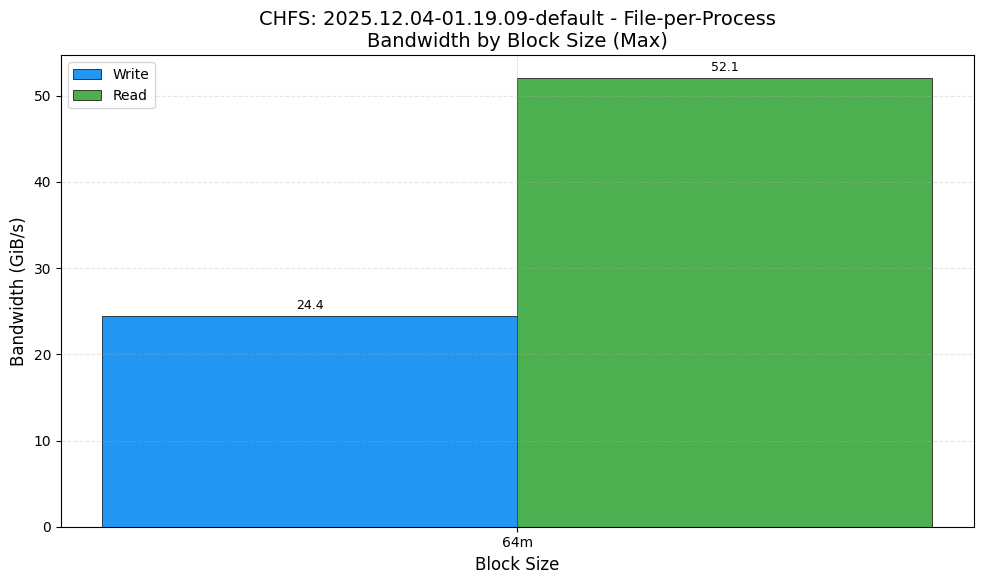

In [9]:
if filtered_detail_df.is_empty() or not SELECTED_EXPERIMENTS:
    print("No data to plot.")
else:
    if len(SELECTED_EXPERIMENTS) == 1:
        exp_df = filtered_detail_df.filter(pl.col("experiment") == SELECTED_EXPERIMENTS[0])
        experiment_label = SELECTED_EXPERIMENTS[0]
    else:
        exp_df = filtered_detail_df
        experiment_label = f"{len(SELECTED_EXPERIMENTS)} experiments"
    
    for access_mode in ["File-per-Process", "Shared File"]:
        mode_df = exp_df.filter(pl.col("access_mode") == access_mode)
        if mode_df.is_empty():
            continue
            
        grouped = (
            mode_df
            .group_by(["block_size_str", "operation"])
            .agg([
                pl.col("bw_gib").max().alias("bw_gib_max"),
            ])
            .sort("block_size_str")
        )
        
        pivot_df = grouped.pivot(
            values="bw_gib_max",
            index="block_size_str",
            on="operation"
        ).to_pandas().set_index("block_size_str")
        
        size_order = ['64m', '256m', '512m', '1g', '2g', '4g']
        pivot_df = pivot_df.reindex([s for s in size_order if s in pivot_df.index])
        
        if pivot_df.empty:
            continue
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        x = range(len(pivot_df))
        width = 0.35
        
        colors = {'write': '#2196F3', 'read': '#4CAF50'}
        
        if 'write' in pivot_df.columns:
            ax.bar([i - width/2 for i in x], pivot_df['write'], width, 
                   label='Write', color=colors['write'], edgecolor='black', linewidth=0.5)
        if 'read' in pivot_df.columns:
            ax.bar([i + width/2 for i in x], pivot_df['read'], width,
                   label='Read', color=colors['read'], edgecolor='black', linewidth=0.5)
        
        ax.set_xlabel('Block Size')
        ax.set_ylabel('Bandwidth (GiB/s)')
        ax.set_title(f'CHFS: {experiment_label} - {access_mode}\nBandwidth by Block Size (Max)')
        ax.set_xticks(x)
        ax.set_xticklabels(pivot_df.index)
        ax.legend(loc='upper left')
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        for bars in ax.containers:
            ax.bar_label(bars, fmt='%.1f', padding=3, fontsize=9)
        
        plt.tight_layout()
        save(fig, f"chfs_bandwidth_by_blocksize_{slugify(experiment_label)}_{slugify(access_mode)}")
        plt.show()
        plt.close(fig)

## Scalability Analysis

ノード数・プロセス数に対するスケーラビリティを確認します。

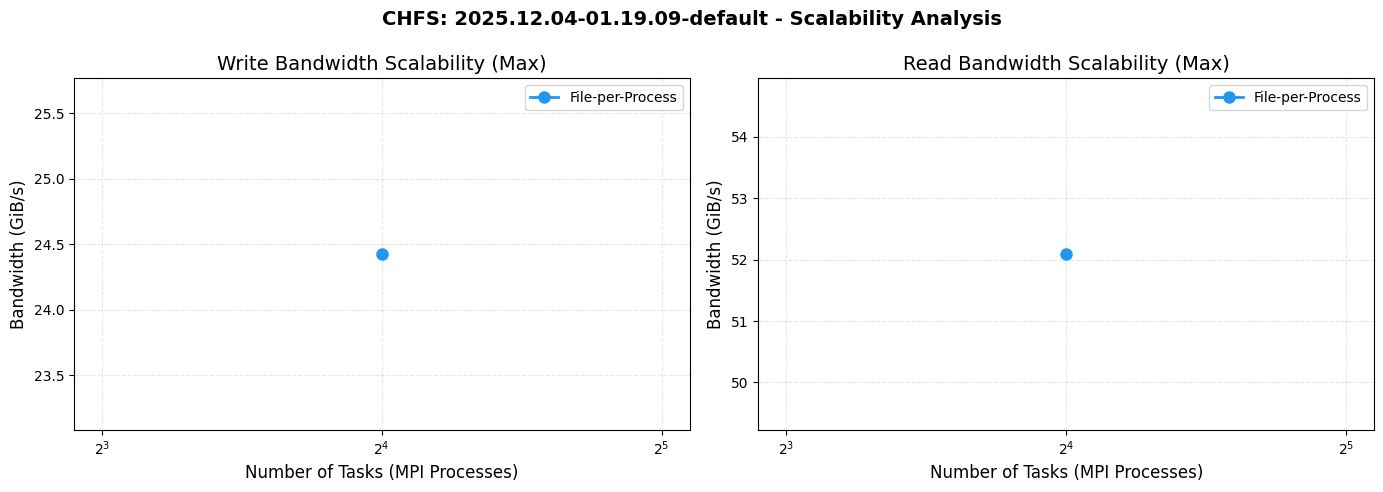

In [10]:
if filtered_detail_df.is_empty() or not SELECTED_EXPERIMENTS:
    print("No data to plot.")
else:
    if len(SELECTED_EXPERIMENTS) == 1:
        exp_df = filtered_detail_df.filter(pl.col("experiment") == SELECTED_EXPERIMENTS[0])
        experiment_label = SELECTED_EXPERIMENTS[0]
    else:
        exp_df = filtered_detail_df
        experiment_label = f"{len(SELECTED_EXPERIMENTS)} experiments"
    
    scalability = (
        exp_df
        .group_by(["num_tasks", "operation", "access_mode"])
        .agg([
            pl.col("bw_gib").max().alias("bw_gib_max"),
            pl.col("nnodes").first().alias("nodes"),
        ])
        .sort("num_tasks")
    )
    
    if scalability.is_empty():
        print("No scalability data available.")
    else:
        pdf = scalability.to_pandas()
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        for ax, operation in zip(axes, ['write', 'read']):
            op_df = pdf[pdf['operation'] == operation]
            
            for access_mode, marker, color in [('File-per-Process', 'o', '#2196F3'), ('Shared File', 's', '#FF9800')]:
                mode_df = op_df[op_df['access_mode'] == access_mode]
                if mode_df.empty:
                    continue
                ax.plot(
                    mode_df['num_tasks'],
                    mode_df['bw_gib_max'],
                    marker=marker,
                    markersize=8,
                    linewidth=2,
                    label=access_mode,
                    color=color,
                )
            
            ax.set_xlabel('Number of Tasks (MPI Processes)')
            ax.set_ylabel('Bandwidth (GiB/s)')
            ax.set_title(f'{operation.capitalize()} Bandwidth Scalability (Max)')
            ax.legend()
            ax.grid(alpha=0.3, linestyle='--')
            ax.set_xscale('log', base=2)
        
        fig.suptitle(f'CHFS: {experiment_label} - Scalability Analysis', fontsize=14, fontweight='bold')
        plt.tight_layout()
        save(fig, f"chfs_scalability_{slugify(experiment_label)}")
        plt.show()
        plt.close(fig)

## Read vs Write Comparison

Read/Writeの帯域比較を散布図で可視化します。

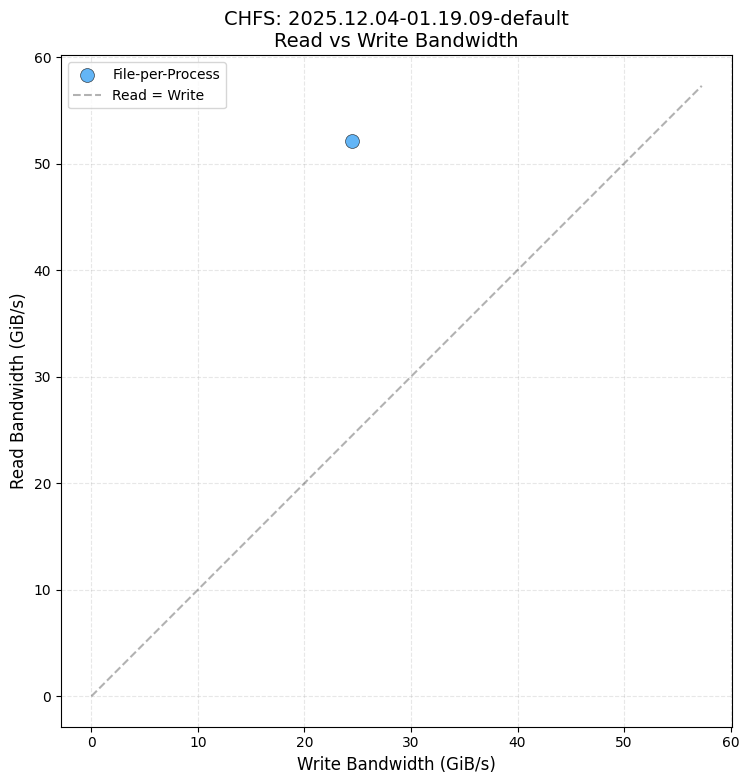

In [11]:
if filtered_detail_df.is_empty() or not SELECTED_EXPERIMENTS:
    print("No data to plot.")
else:
    if len(SELECTED_EXPERIMENTS) == 1:
        exp_df = filtered_detail_df.filter(pl.col("experiment") == SELECTED_EXPERIMENTS[0])
        experiment_label = SELECTED_EXPERIMENTS[0]
    else:
        exp_df = filtered_detail_df
        experiment_label = f"{len(SELECTED_EXPERIMENTS)} experiments"
    
    write_df = exp_df.filter(pl.col("operation") == "write").select(
        "run_index", "access_mode", "block_size_str", "num_tasks",
        pl.col("bw_gib").alias("write_bw_gib")
    )
    read_df = exp_df.filter(pl.col("operation") == "read").select(
        "run_index", "access_mode", "block_size_str", "num_tasks",
        pl.col("bw_gib").alias("read_bw_gib")
    )
    
    merged = write_df.join(
        read_df,
        on=["run_index", "access_mode", "block_size_str", "num_tasks"],
        how="inner"
    ).to_pandas()
    
    if merged.empty:
        print("No paired write/read data available.")
    else:
        fig, ax = plt.subplots(figsize=(8, 8))
        
        colors = {'File-per-Process': '#2196F3', 'Shared File': '#FF9800'}
        markers = {'File-per-Process': 'o', 'Shared File': 's'}
        
        for mode in merged['access_mode'].unique():
            mode_df = merged[merged['access_mode'] == mode]
            ax.scatter(
                mode_df['write_bw_gib'],
                mode_df['read_bw_gib'],
                c=colors.get(mode, 'gray'),
                marker=markers.get(mode, 'o'),
                s=100,
                alpha=0.7,
                edgecolors='black',
                linewidths=0.5,
                label=mode
            )
        
        max_val = max(merged['write_bw_gib'].max(), merged['read_bw_gib'].max()) * 1.1
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='Read = Write')
        
        ax.set_xlabel('Write Bandwidth (GiB/s)')
        ax.set_ylabel('Read Bandwidth (GiB/s)')
        ax.set_title(f'CHFS: {experiment_label}\nRead vs Write Bandwidth')
        ax.legend()
        ax.grid(alpha=0.3, linestyle='--')
        ax.set_aspect('equal')
        
        plt.tight_layout()
        save(fig, f"chfs_read_vs_write_{slugify(experiment_label)}")
        plt.show()
        plt.close(fig)

## Summary Statistics Table

実験の統計サマリを表形式で表示します。

In [12]:
if filtered_detail_df.is_empty() or not SELECTED_EXPERIMENTS:
    print("No data available.")
else:
    exp_df = filtered_detail_df
    
    stats = (
        exp_df
        .group_by(["experiment", "access_mode", "operation", "block_size_str"])
        .agg([
            pl.col("bw_gib").mean().round(2).alias("Mean (GiB/s)"),
            pl.col("bw_gib").max().round(2).alias("Max (GiB/s)"),
            pl.col("bw_gib").min().round(2).alias("Min (GiB/s)"),
            pl.col("bw_gib").std().round(2).alias("Std (GiB/s)"),
            pl.len().alias("Samples"),
        ])
        .sort(["experiment", "access_mode", "operation", "block_size_str"])
    )
    
    experiment_label = SELECTED_EXPERIMENTS[0] if len(SELECTED_EXPERIMENTS) == 1 else f"{len(SELECTED_EXPERIMENTS)} experiments"
    print(f"\nCHFS: {experiment_label} - Summary Statistics\n")
    display(stats.to_pandas())


CHFS: 2025.12.04-01.19.09-default - Summary Statistics



,experiment,access_mode,operation,block_size_str,Mean (GiB/s),Max (GiB/s),Min (GiB/s),Std (GiB/s),Samples
0,2025.12.04-01.19.09-default,File-per-Process,read,64m,52.09,52.09,52.09,NaN,1
1,2025.12.04-01.19.09-default,File-per-Process,write,64m,24.42,24.42,24.42,NaN,1


## Export Processed Data

整形済みのサマリと詳細データをJSONとして保存します。

In [13]:
if filtered_summary_df.is_empty() and filtered_detail_df.is_empty():
    print("No IOR results to export.")
else:
    experiment_suffix = "_".join(slugify(e) for e in SELECTED_EXPERIMENTS) if SELECTED_EXPERIMENTS else "all"
    
    if not filtered_summary_df.is_empty():
        summary_out = DATA_DIR / f"chfs_ior_summary_{experiment_suffix}.json"
        summary_out.parent.mkdir(parents=True, exist_ok=True)
        summary_out.write_text(
            json.dumps(filtered_summary_df.to_pandas().to_dict(orient="records"), ensure_ascii=False, indent=2)
        )
        print(f"Wrote {summary_out}")
    else:
        print("No summary records to export.")
        
    if not filtered_detail_df.is_empty():
        detail_out = DATA_DIR / f"chfs_ior_detail_{experiment_suffix}.json"
        detail_out.parent.mkdir(parents=True, exist_ok=True)
        detail_out.write_text(
            json.dumps(filtered_detail_df.to_pandas().to_dict(orient="records"), ensure_ascii=False, indent=2)
        )
        print(f"Wrote {detail_out}")
    else:
        print("No detailed records to export.")

Wrote /work/0/NBB/rmaeda/workspace/rust/benchfs/plot/processed/chfs/chfs_ior_summary_2025.12.04-01.19.09-default.json
Wrote /work/0/NBB/rmaeda/workspace/rust/benchfs/plot/processed/chfs/chfs_ior_detail_2025.12.04-01.19.09-default.json
